In [44]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 16,12
 
# construct the argument parser and parse the arguments
IMAGE = 'sap1.jpg'
EAST_DETECTOR = 'frozen_east_text_detection.pb'
MIN_CONFIDENCE = 0.5
WIDTH = 320
HEIGHT = 320

In [45]:
matplotlib.rcParams['figure.figsize'] = 16,12

In [46]:
image = cv2.imread('images-text/' + IMAGE)
orig = image.copy()
(H, W) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
(newW, newH) = (WIDTH, HEIGHT)
rW = W / float(newW)
rH = H / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [47]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [ "feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

In [48]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(EAST_DETECTOR)
 
# construct a blob from the image and then perform a forward pass of the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
 
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.362031 seconds


In [49]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

print(numRows)
print(numCols)
 
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

80
80


In [50]:
# loop over the number of columns
ignored = 0
print(scoresData)
for x in range(0, numCols):
    # if our score does not have sufficient probability, ignore it
    if scoresData[x] < MIN_CONFIDENCE:
        ignored += 1
        continue
 
    # compute the offset factor as our resulting feature maps will be 4x smaller than the input image
    (offsetX, offsetY) = (x * 4.0, y * 4.0)
 
    # extract the rotation angle for the prediction and then compute the sin and cosine
    angle = anglesData[x]
    cos = np.cos(angle)
    sin = np.sin(angle)
 
    # use the geometry volume to derive the width and height of
    # the bounding box
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]
 
    # compute both the starting and ending (x, y)-coordinates for the text prediction bounding box
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    startX = int(endX - w)
    startY = int(endY - h)
 
    # add the bounding box coordinates and probability score to our respective lists
    rects.append((startX, startY, endX, endY))
    confidences.append(scoresData[x])
    
print('ignored = ' + str(ignored))

[1.85175946e-08 3.36749864e-08 2.57059973e-08 7.31717309e-09
 4.77446171e-09 8.76997941e-09 1.32521158e-08 2.14598188e-08
 2.87983593e-08 3.06890406e-08 2.80017485e-08 2.73623773e-08
 2.67568385e-08 2.48806771e-08 2.37680400e-08 2.39297027e-08
 2.61929607e-08 1.71082810e-08 1.08489955e-08 6.47983800e-09
 4.16112833e-09 1.77128290e-09 9.58275015e-10 6.88901769e-10
 4.72810568e-10 1.12668375e-10 7.46515627e-11 6.92627344e-11
 6.32748090e-11 5.50687655e-11 1.66538797e-10 1.53553878e-10
 2.33162600e-10 1.56787180e-10 1.67470510e-10 1.93169952e-10
 1.37638775e-10 1.66750169e-10 3.29995670e-10 4.27663988e-10
 4.52777066e-10 2.12326934e-10 1.41087808e-10 2.66668354e-10
 3.76168097e-10 3.95360106e-10 3.36341899e-10 2.84256008e-10
 1.68124056e-10 5.13517666e-11 2.40070654e-11 1.62155740e-11
 6.10067413e-11 2.96098458e-11 4.16252068e-11 1.59352823e-10
 4.31001762e-10 7.89847798e-10 9.57869339e-10 7.77752140e-10
 6.49036047e-10 8.30085445e-10 1.21862209e-09 2.58162425e-09
 4.42498038e-09 5.287105

0


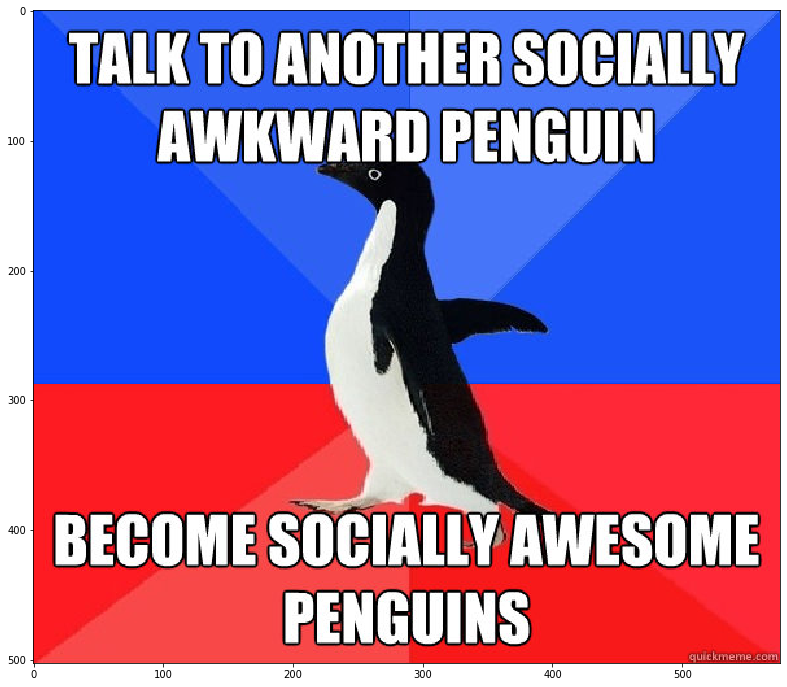

In [51]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
 
print(len(boxes))    

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))

In [52]:
import sys
import os
import re
import cv2

class MemeOCR:
    def __init__(self):
        self._white_thresh = 240
        self._tmp_image_fname = '/tmp/memeocr.jpg'
        self._tmp_txt_base = '/tmp/memeocr'
        self._tmp_txt_fname = self._tmp_txt_base + '.txt'
        self._template_image = None
        self._keep_tmp_files = False

    def set_template(self, fname):
        self._template_image = self._read_image(fname)

    def recognize(self, fname):
        txt = None
        img = self._read_image(fname)
        self._thresh_words(img, self._template_image)
        self._exec_tesseract()
        txt = self._read_txt()
        self._delete_tmp_files()
        return txt

    def _read_image(self, fname):
        try:
            img = cv2.imread(fname)
        except IOError:
            img = None
        return img

    def _thresh_words(self, img, template):
        if img is None:
            return

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if all([elem >= self._white_thresh for elem in img[i][j]]):
                    img[i][j] = (255, 255, 255)
                else:
                    img[i][j] = (0, 0, 0)

        cv2.imwrite(self._tmp_image_fname, img)

    def _exec_tesseract(self):
        cmd = 'env TESSDATA_PREFIX=./tessdata tesseract -l joh %s %s > /dev/null' % (self._tmp_image_fname, self._tmp_txt_base)
        os.system(cmd)

    def _read_txt(self):
        try:
            fr = open(self._tmp_txt_fname)
        except IOError:
            return None
        content = fr.read()
        fr.close()
        blocks = re.split(r'\n\n', content)
        lines = [re.sub(r'\s+', ' ', block) for block in blocks if block.strip()]
        return lines

    def _delete_tmp_files(self):
        if self._keep_tmp_files:
            return
        if os.path.exists(self._tmp_image_fname):
            os.remove(self._tmp_image_fname)
        if os.path.exists(self._tmp_txt_fname):
            os.remove(self._tmp_txt_fname)

In [53]:
import sys

tmp_image_fname = 'memeocr.jpg'
meme_fname = 'images-text/pr3.jpg'

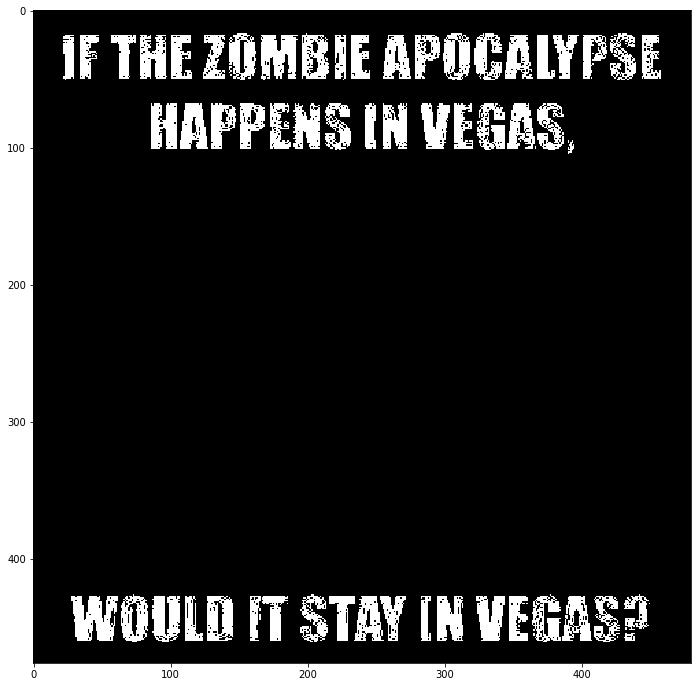

In [54]:
img = cv2.imread(meme_fname)

img_copy = img.copy()

plt.imshow(img)

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if all([elem >= 240 for elem in img[i][j]]):
            img[i][j] = (255, 255, 255)
        else:
            img[i][j] = (0, 0, 0)

img2 = img > 240
            
plt.imshow(img)
plt.imshow(img)

In [55]:
from PIL import Image
import requests
from io import BytesIO
import csv

def get_image(link):
    ind = link.rfind('/')
    img_res = requests.get(link)
    img = Image.open(BytesIO(img_res.content))
    img.save(link[ind+1:])

In [56]:
get_image('https://i.imgflip.com/3lulj4.jpg')